# Assignment 3 - Neural Networks

210720U - Wijesinghe C.D.

## Question 1 - Backpropagation with Hidden Layer

### Importing and loading data

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Dataloading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 50

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Hyper-parameters

In [ ]:
# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR-10 image size)
K = 10  # Output size (number of classes in CIFAR-10)
std = 1e-5
hidden_units = 100

# Input to hidden layer weights and biases
w1 = torch.randn(Din, hidden_units) * std
b1 = torch.zeros(hidden_units)

# Hidden to output layer weights and biases
w2 = torch.randn(hidden_units, K) * std
b2 = torch.zeros(K)

# Hyperparameters
iterations = 10
lr = 1e-2  # Learning rate (Increased)
lr_decay = 0.99  # Learning rate decay
reg = 0.0  # Regularization
loss_history = []

In [ ]:
# sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# CrossEntropy Loss
def CrossEntropyLoss(y_pred, y_true):
    smooth = 1e-9
    loss = -torch.sum(y_true * torch.log(y_pred + smooth)) / y_true.shape[0]
    return loss

### Training loop

In [ ]:
# 3. Training Loop
for t in range(iterations):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get inputs and labels
        inputs, labels = data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float()  # Convert labels to one-hot encoding

        # Forward pass with middle layer
        hidden = sigmoid(x_train.mm(w1) + b1)  # Middle layer with sigmoid activation
        y_pred = torch.softmax(hidden.mm(w2) + b2, dim=1) # Output layer activation

        # Loss calculation (CrossEntropy loss with regularization for both layers)
        loss = CrossEntropyLoss(y_pred, y_train_onehot)  # Cross-entropy loss
        loss += reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))  # Also add regularization term
        loss_history.append(loss.item())
        running_loss += loss.item()

        # Backpropagation
        dy_pred = (y_pred - y_train_onehot) # Loss derivative
        dw2 = hidden.t().mm(dy_pred) + reg * w2
        db2 = dy_pred.sum(dim=0)

        # Backpropagation to hidden layer
        dhidden = dy_pred.mm(w2.t()) * (hidden * (1 - hidden))  # Derivative of sigmoid
        dw1 = x_train.t().mm(dhidden) + reg * w1
        db1 = dhidden.sum(dim=0)

        # Parameter update
        w1 -= lr * dw1
        b1 -= lr * db1
        w2 -= lr * dw2
        b2 -= lr * db2

    # Print loss for every epoch
    if t % 1 == 0:
        print(f"Epoch {t + 1} / {iterations}, Loss: {running_loss / len(trainloader)}")

    # Learning rate decay
    lr *= lr_decay

Epoch 1 / 10, Loss: 1.8768153903484344
Epoch 2 / 10, Loss: 1.670587791442871
Epoch 3 / 10, Loss: 1.5843013767004013
Epoch 4 / 10, Loss: 1.521163777768612
Epoch 5 / 10, Loss: 1.4651328283548355
Epoch 6 / 10, Loss: 1.4209067499637604
Epoch 7 / 10, Loss: 1.3806527979969978
Epoch 8 / 10, Loss: 1.3446481263637542
Epoch 9 / 10, Loss: 1.308588595688343
Epoch 10 / 10, Loss: 1.2738817858695983


### Plot Loss Curve

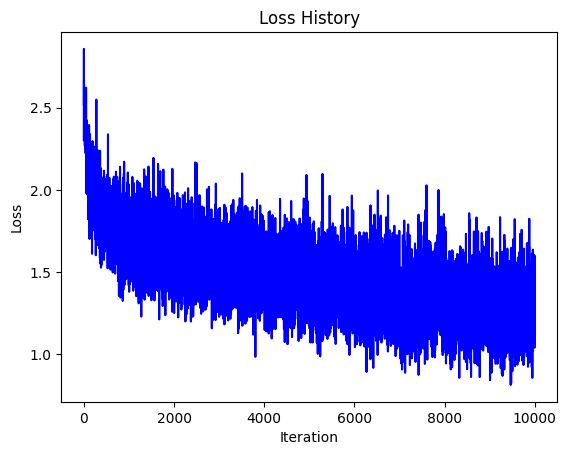

In [ ]:
# 4. Plotting the Loss History
plt.figure()
plt.plot(loss_history, color='blue')
plt.title("Loss History")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
# 5. Calculate Accuracy on Training Set
correct_train = 0
total_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        Ntr = inputs.shape[0]
        x_train = inputs.view(Ntr, -1)
        y_train_onehot = nn.functional.one_hot(labels, K).float()

        # Forward pass
        hidden_layer = sigmoid(x_train.mm(w1) + b1)  # Middle layer with sigmoid activation
        y_train_pred = hidden_layer.mm(w2) + b2  # Output layer activation
        predicted_train = torch.argmax(y_train_pred, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

train_acc = 100 * correct_train / total_train
print(f"Training accuracy: {train_acc:.2f}%")

Training accuracy: 56.93%


In [ ]:
# 6. Calculate Accuracy on Test Set
correct_test = 0
total_test = 0
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        Nte = inputs.shape[0]
        x_test = inputs.view(Nte, -1)
        y_test_onehot = nn.functional.one_hot(labels, K).float()

        # Forward pass
        hidden_layer = sigmoid(x_test.mm(w1) + b1)  # Middle layer with sigmoid activation
        y_test_pred = hidden_layer.mm(w2) + b2  # Output layer activation
        predicted_test = torch.argmax(y_test_pred, dim=1)
        total_test += labels.size(0)
        correct_test += (predicted_test == labels).sum().item()

test_acc = 100 * correct_test / total_test
print(f"Test accuracy: {test_acc:.2f}%")

Test accuracy: 46.70%


The train and test accuracies are as follows

| Split | Accuracy |
|----------|----------|
| Train | 56.93% |
| Test | 46.70% |

### Discussion
It can be observed that although the model's loss has been reduced with each epoch, the training and test accuracies are still low. This can be due to the model being too simple so that it underfits the dataset. Including more hidden layers can help achieve a greater accuracy.

## Question 2 - LeNet-5 Network

### Import modules

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define hyper parameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_EPOCHS = 10

# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Load dataset

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

### Model Architecture

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = LeNet5().to(device)

# Select loss function
cost = nn.CrossEntropyLoss()

# Setting the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

### Training Loop

In [ ]:
losses = []

for epoch in range(NUM_EPOCHS):
    # Set train mode
    model.train()

    # Calculate losses, accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Accuracy for this epoch
    train_accuracy = 100 * correct / total
    losses.append(running_loss / len(train_loader))
    print(f'Epoch: {epoch + 1}/{NUM_EPOCHS} | Loss: {running_loss / len(train_loader):.4f} | Training Accuracy: {train_accuracy:.2f}%')

Epoch: 1/10 | Loss: 0.4032 | Training Accuracy: 86.67%
Epoch: 2/10 | Loss: 0.0629 | Training Accuracy: 98.07%
Epoch: 3/10 | Loss: 0.0434 | Training Accuracy: 98.64%
Epoch: 4/10 | Loss: 0.0341 | Training Accuracy: 98.90%
Epoch: 5/10 | Loss: 0.0260 | Training Accuracy: 99.20%
Epoch: 6/10 | Loss: 0.0239 | Training Accuracy: 99.20%
Epoch: 7/10 | Loss: 0.0177 | Training Accuracy: 99.41%
Epoch: 8/10 | Loss: 0.0162 | Training Accuracy: 99.46%
Epoch: 9/10 | Loss: 0.0134 | Training Accuracy: 99.53%
Epoch: 10/10 | Loss: 0.0119 | Training Accuracy: 99.61%


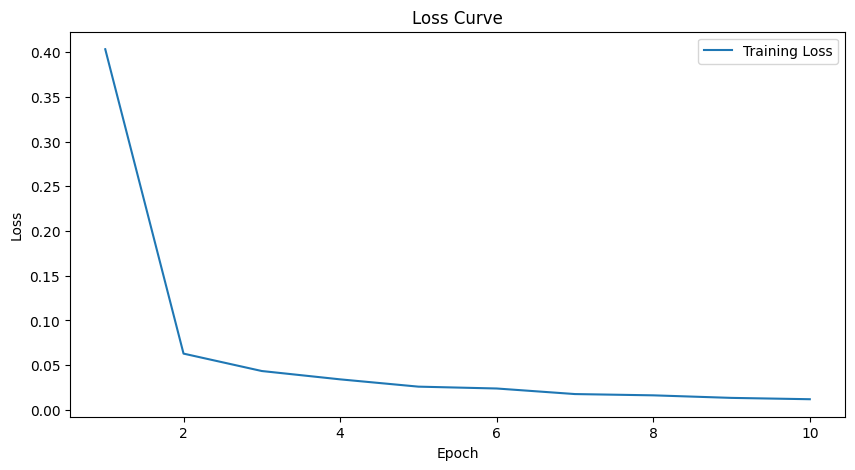

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS+1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [ ]:
# Set eval mode
model.eval()
correct = 0
total = 0

# Get train predictions
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

train_accuracy = 100 * correct / total
print(f'Train Accuracy: {train_accuracy:.2f}%')

Train Accuracy: 99.83%


In [ ]:
# Set eval mode
model.eval()
correct = 0
total = 0

# Get test predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 99.18%


The train and test accuracies are as follows

| Split | Accuracy |
|----------|----------|
| Train | 99.83% |
| Test | 99.18% |

Both train and test accuracies are similar therefore the model has perfectly fit for the data.

# Question 3


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

In [ ]:
# Download dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

!unzip /content/hymenoptera_data.zip -d /content/

--2024-11-14 16:21:03--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 3.165.102.31, 3.165.102.62, 3.165.102.36, ...
Connecting to download.pytorch.org (download.pytorch.org)|3.165.102.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   196MB/s    in 0.2s    

2024-11-14 16:21:04 (196 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  /content/hymenoptera_data.zip
   creating: /content/hymenoptera_data/
   creating: /content/hymenoptera_data/train/
   creating: /content/hymenoptera_data/train/ants/
  inflating: /content/hymenoptera_data/train/ants/0013035.jpg  
  inflating: /content/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: /content/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: /content/hymenoptera_data/

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load dataset
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


### Plot some example images

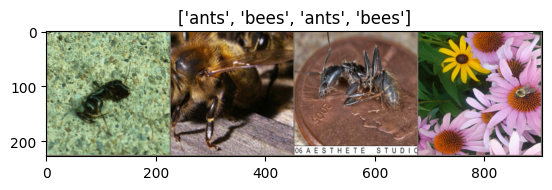

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## (a) Fine tuning the model

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 196MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5248 Acc: 0.7459
val Loss: 0.4223 Acc: 0.8170

Epoch 1/24
----------
train Loss: 0.5086 Acc: 0.7828
val Loss: 0.2569 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.7114 Acc: 0.7377
val Loss: 0.2206 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5187 Acc: 0.7828
val Loss: 0.2978 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.4577 Acc: 0.8197
val Loss: 0.1837 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.5282 Acc: 0.7951
val Loss: 0.2015 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5283 Acc: 0.7746
val Loss: 0.2935 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.4449 Acc: 0.7992
val Loss: 0.2476 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3348 Acc: 0.8443
val Loss: 0.1923 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3190 Acc: 0.8770
val Loss: 0.2028 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3929 Acc: 0.8238
val Loss: 0.1769 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3009 Acc: 0.8770
val Loss: 0.1709 Acc: 0.9477

Ep

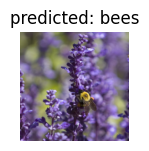

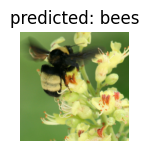

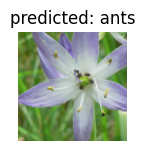

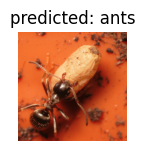

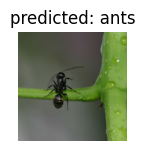

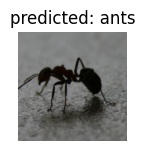

In [ ]:
visualize_model(model_ft)

The train and test accuracies are as follows

| Split | Accuracy |
|----------|----------|
| Train | 88.93% |
| Validation | 95.42% |

## (b) Using model as feature extractor

In [ ]:
model_fe = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_fe.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, 2)

model_fe = model_fe.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_fe = optim.SGD(model_fe.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fe, step_size=7, gamma=0.1)

In [ ]:
model_fe = train_model(model_fe, criterion, optimizer_fe, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7118 Acc: 0.6270
val Loss: 0.2154 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.5486 Acc: 0.7500
val Loss: 0.4908 Acc: 0.7778

Epoch 2/24
----------
train Loss: 0.5096 Acc: 0.7459
val Loss: 0.2078 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.4997 Acc: 0.7992
val Loss: 0.2909 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.5519 Acc: 0.7582
val Loss: 0.2787 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.9381 Acc: 0.6926
val Loss: 0.1570 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.7896 Acc: 0.7172
val Loss: 0.1863 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3829 Acc: 0.7992
val Loss: 0.2127 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4030 Acc: 0.8197
val Loss: 0.2005 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3699 Acc: 0.8402
val Loss: 0.2710 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3955 Acc: 0.8197
val Loss: 0.1872 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.2960 Acc: 0.8811
val Loss: 0.1945 Acc: 0.9608

Ep

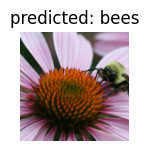

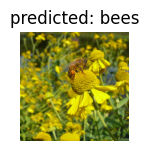

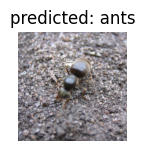

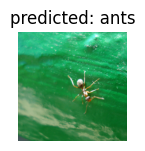

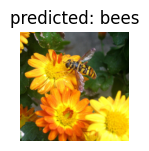

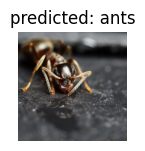

In [ ]:
visualize_model(model_fe)

plt.ioff()
plt.show()

The train and test accuracies are as follows

| Split | Accuracy |
|----------|----------|
| Train | 83.61% |
| Test | 93.46% |

Finetuning the entire model gives a greater test accuracy than using it as a feature extractor. This is because the model adapts to the new dataset starting from its earliest layers to the outermost dense layers. Thus it learns to extract features unique to the dataset. In contrast, when using the model as a feature extractor, the extracted features are not unique to the new dataset. Instead it extracts the same features as IMAGENET dataset. Only the linear layers are trained. Therefore there is a subtle lower accuracy when using this approach.